In [1]:
import os
import pandas as pd
from sklearn import preprocessing

import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)

In [2]:
path = "../data/foursquare"
df = pd.read_csv(os.path.join(path, "dataset_TSMC2014_NYC.csv"))
df.rename(
    columns={
        "userId": "user_id", 
        "venueId": "item_id", 
        "venueCategoryId": 
        "item_category_id", 
        "venueCategory": 
        "item_category"
    }, 
    inplace=True
)
df.sort_values("utcTimestamp")
df

,user_id,item_id,item_category_id,item_category,latitude,longitude,timezoneOffset,utcTimestamp
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
...,...,...,...,...,...,...,...,...
227423,688,3fd66200f964a52000e71ee3,4bf58dd8d48988d1e7931735,Music Venue,40.733596,-74.003139,-300,Sat Feb 16 02:29:11 +0000 2013
227424,560,4bca32ff0687ef3be789dbcc,4bf58dd8d48988d16c941735,Burger Joint,40.745719,-73.993720,-300,Sat Feb 16 02:31:35 +0000 2013
227425,945,50a77716e4b0b5a9492f6f56,4bf58dd8d48988d103941735,Home (private),40.854365,-73.883070,-300,Sat Feb 16 02:33:16 +0000 2013
227426,671,4514efe0f964a520e7391fe3,4bf58dd8d48988d11d941735,Bar,40.735981,-74.029309,-300,Sat Feb 16 02:34:31 +0000 2013


In [3]:
item_encoder = preprocessing.LabelEncoder().fit(df.item_id.values)
df.item_id = item_encoder.transform(df.item_id.values)

user_encoder = preprocessing.LabelEncoder().fit(df.user_id.values)
df.user_id = user_encoder.transform(df.user_id.values)

item_category_encoder = preprocessing.LabelEncoder().fit(df.item_category_id.values)
df.item_category_id = item_category_encoder.transform(df.item_category_id.values)

df

,user_id,item_id,item_category_id,item_category,latitude,longitude,timezoneOffset,utcTimestamp
0,469,2388,75,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012
1,978,3921,252,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012
2,68,20328,6,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012
3,394,15114,8,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012
4,86,23550,234,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012
...,...,...,...,...,...,...,...,...
227423,687,0,266,Music Venue,40.733596,-74.003139,-300,Sat Feb 16 02:29:11 +0000 2013
227424,559,15284,148,Burger Joint,40.745719,-73.993720,-300,Sat Feb 16 02:31:35 +0000 2013
227425,944,37855,6,Home (private),40.854365,-73.883070,-300,Sat Feb 16 02:33:16 +0000 2013
227426,670,1773,56,Bar,40.735981,-74.029309,-300,Sat Feb 16 02:34:31 +0000 2013


# PMF

In [4]:
from __future__ import print_function

import os
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data

import matplotlib.pyplot as plt

import sys 
sys.path.append('..')

from src.model.pmf import PMF

In [5]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

In [6]:
batch_size = 1000
epoches = 10000
no_cuda = False
seed = 1
weight_decay = 0.1
embedding_feature_size = 50
ratio = 0.8
lr = 0.0001
momentum = 0.9

In [7]:
NUM_ITEMS = df.item_id.max() + 1
NUM_USERS = df.user_id.max() + 1

print(NUM_USERS, NUM_ITEMS)

1083 38333


In [8]:
df["reward"] = 1
data = df[["user_id", "item_id", "reward"]].values

In [9]:
# Split data
train_data = data[:int(ratio * data.shape[0])]
vali_data = data[int(ratio * data.shape[0]): int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio + (1 - ratio) / 2) * data.shape[0]) :]

In [10]:
no_cuda=False

# Get CUDA device if available
cuda = torch.cuda.is_available()
 
# Set device to CUDA or CPU, depending on availability and desire
device = torch.device("cuda" if cuda and no_cuda else "cpu")
 
# Generate and apply seeds
torch.manual_seed(seed=seed)
if cuda:
    torch.cuda.empty_cache()
    torch.cuda.manual_seed(seed=seed)
 
# Specify number of workers for cuda
kwargs = {"num_workers":1, "pin_memory":True} if cuda else {}
 
# Construct Data Loaders
train_data_loader = torch.utils.data.DataLoader(torch.from_numpy(train_data), batch_size=batch_size, shuffle=False, **kwargs)
test_data_loader = torch.utils.data.DataLoader(torch.from_numpy(test_data), batch_size=batch_size, shuffle=False, **kwargs)

In [11]:
# Initialize model
model = PMF(n_users=NUM_USERS, n_items=NUM_ITEMS, n_factors=embedding_feature_size, no_cuda=no_cuda)
 
# Move model to CUDA if CUDA selected
if cuda and not no_cuda:
    model.cuda()
    print("Model moved to CUDA")
 
# Set loss function
loss_function = nn.MSELoss(reduction="sum")

# Set optimizer (uncomment Adam for adam)
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

Model moved to CUDA


In [12]:
# Function for training one epoch
def train(epoch, train_data_loader):
    # Initialize
    model.train()
    epoch_loss = 0.0
    optimizer.zero_grad()
 
    # Go through batches
    for batch_idx, ele in enumerate(train_data_loader):
        # Zero optimizer gradient
        optimizer.zero_grad()
 
        # Extract user_id_nums: row 0, item_id_nums: col 1 , ratings: val 2
        row = ele[:, 0]
        col = ele[:, 1]
        val = ele[:, 2]
 
        # Set to variables
        row = Variable(row.long())
        if isinstance(col, list):
            col = tuple(Variable(c.long()) for c in col)
        else:
            col = Variable(col.long())
        val = Variable(val.float())

        # Move data to CUDA
        if cuda and not no_cuda:
            row = row.cuda()
            col = col.cuda()
            val = val.cuda()
 
        # Train
        preds = model.forward(row, col)
        loss = loss_function(preds, val)
        loss.backward()
        optimizer.step()
 
        # Update epoch loss
        epoch_loss += loss.data
 
    epoch_loss /= train_data_loader.dataset.shape[0]
    return epoch_loss

In [13]:
# Training Model
count = 0
train_loss_list = []
last_vali_rmse = None
train_rmse_list = []
vali_rmse_list = []
print("parameters are: train ratio:{:f},batch_size:{:d}, epoches:{:d}, weight_decay:{:f}".format(ratio, batch_size, epoches, weight_decay))
print(model)

# Go through epochs
for epoch in range(1, epoches+1):

    # Train epoch
    train_epoch_loss = train(epoch, train_data_loader)

    # Get epoch loss
    train_loss_list.append(train_epoch_loss.cpu())

    # Move validation data to CUDA
    if cuda and not no_cuda:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long()).cuda()
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long()).cuda()
    else:
        vali_row = Variable(torch.from_numpy(vali_data[:, 0]).long())
        vali_col = Variable(torch.from_numpy(vali_data[:, 1]).long())

    # Get validation predictions
    vali_preds = model.predict(vali_row, vali_col)

    # Calculate train rmse loss
    train_rmse = np.sqrt(train_epoch_loss.cpu())

    # Calculate validation rmse loss
    if cuda and not no_cuda:
        vali_rmse = RMSE(vali_preds.cpu().data.numpy(), vali_data[:, 2])
    else:
        vali_rmse = RMSE(vali_preds.data.numpy(), vali_data[:, 2])

    # Add losses to rmse loss lists
    train_rmse_list.append(train_rmse)
    vali_rmse_list.append(vali_rmse)

    print("Training epoch:{: d}, training rmse:{: .6f}, vali rmse:{:.6f}". \
            format(epoch, train_rmse, vali_rmse))

    # Early stop condition
    if last_vali_rmse and last_vali_rmse < vali_rmse:
        break
    else:
        last_vali_rmse = vali_rmse
    

parameters are: train ratio:0.800000,batch_size:1000, epoches:10000, weight_decay:0.100000
PMF(
  (user_embeddings): Embedding(1083, 50)
  (item_embeddings): Embedding(38333, 50)
  (ub): Embedding(1083, 1)
  (ib): Embedding(38333, 1)
)
Training epoch: 1, training rmse: 0.860852, vali rmse:0.852795
Training epoch: 2, training rmse: 0.815543, vali rmse:0.819042
Training epoch: 3, training rmse: 0.768763, vali rmse:0.785244
Training epoch: 4, training rmse: 0.721948, vali rmse:0.752481
Training epoch: 5, training rmse: 0.676863, vali rmse:0.721871
Training epoch: 6, training rmse: 0.635112, vali rmse:0.694188
Training epoch: 7, training rmse: 0.597765, vali rmse:0.669713
Training epoch: 8, training rmse: 0.565183, vali rmse:0.648303
Training epoch: 9, training rmse: 0.537121, vali rmse:0.629581
Training epoch: 10, training rmse: 0.512994, vali rmse:0.613116
Training epoch: 11, training rmse: 0.492133, vali rmse:0.598518
Training epoch: 12, training rmse: 0.473928, vali rmse:0.585467
Train

In [14]:
# Testing Model

# Move test set to CUDA
if cuda and not no_cuda:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long()).cuda()
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long()).cuda()
else:
    test_row = Variable(torch.from_numpy(test_data[:, 0]).long())
    test_col = Variable(torch.from_numpy(test_data[:, 1]).long())
 
# Get test predictions
preds = model.predict(test_row, test_col)
 
# Get test rmse loss
if cuda:
    test_rmse = RMSE(preds.cpu().data.numpy(), test_data[:, 2])
else:
    test_rmse = RMSE(preds.data.numpy(), test_data[:, 2])
print("Test rmse: {:f}".format(test_rmse))

Test rmse: 0.186480


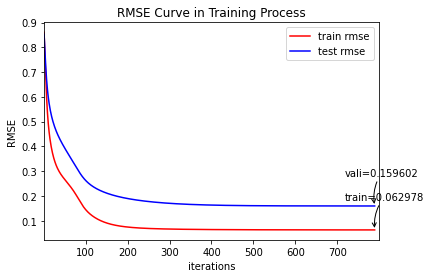

In [15]:
# Create plots
plt.figure(1)
plt.plot(range(1, len(train_rmse_list)+1), train_rmse_list, color="r", label="train rmse")
plt.plot(range(1, len(vali_rmse_list)+1), vali_rmse_list, color="b", label="test rmse")
plt.legend()
plt.annotate(r"train=%f" % (train_rmse_list[-1]), xy=(len(train_rmse_list), train_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.annotate(r"vali=%f" % (vali_rmse_list[-1]), xy=(len(vali_rmse_list), vali_rmse_list[-1]),
             xycoords="data", xytext=(-30, 30), textcoords="offset points", fontsize=10,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))
plt.xlim([1, len(train_rmse_list)+10])
plt.xlabel("iterations")
plt.ylabel("RMSE")
plt.title("RMSE Curve in Training Process")
plt.show()

In [16]:
# Save model
path_to_trained_pmf = "../model/pmf/foursquare_emb_{:d}_ratio_{:f}_bs_{:d}_e_{:d}_wd_{:f}_lr_{:f}_trained_pmf.pt".format(embedding_feature_size, ratio, batch_size, len(train_rmse_list), weight_decay, lr)
torch.save(model.state_dict(), path_to_trained_pmf)

In [18]:
idx =  0
(model.predict(
    torch.tensor([data[idx][0]]).long().to("cuda"), 
    torch.tensor([data[idx][1]]).long().to("cuda")
).cpu().data[0] + 1) / 2, (data[idx][2] + 1) / 2

(tensor(0.9904), 1.0)

# Data Processing

In [4]:
import pandas as pd
import pickle
import numpy as np

import plotly.offline as py
import plotly.express as px
py.init_notebook_mode(connected=True)

In [9]:
df["reward"] = 1

In [10]:
users_dict = {user: [] for user in set(df["user_id"])}

ratings_df_gen = df.iterrows()
users_dict_positive_items = {
    user: [] for user in set(df["user_id"])
}
for data in ratings_df_gen:
    users_dict[data[1]["user_id"]].append(
        (data[1]["item_id"], data[1]["reward"])
    )
    if data[1]["reward"] > 0:
        users_dict_positive_items[data[1]["user_id"]].append(
            (data[1]["item_id"], data[1]["reward"])
        )
users_history_lens = [
    len(users_dict_positive_items[u])
    for u in set(df["user_id"])
]

users_num = max(df["user_id"]) + 1
items_num = max(df["item_id"]) + 1

print(users_num, items_num)

1083 38333


In [11]:
train_users_num = int(users_num * 0.8)
train_users_dict = {k: users_dict.get(k) for k in range(0, train_users_num - 1)}
train_users_history_lens = users_history_lens[:train_users_num]

# Evaluating setting
eval_users_num = int(users_num * 0.2)
eval_users_dict = {
    k: users_dict[k] for k in range(users_num - eval_users_num, users_num)
}
eval_users_history_lens = users_history_lens[-eval_users_num:]


In [18]:
# Save processed data
with open("../data/foursquare/train_users_dict.pkl", "wb") as file:
    pickle.dump(train_users_dict, file)

with open("../data/foursquare/train_users_history_lens.pkl", "wb") as file:
    pickle.dump(train_users_history_lens, file)

with open("../data/foursquare/eval_users_dict.pkl", "wb") as file:
    pickle.dump(eval_users_dict, file)

with open("../data/foursquare/eval_users_history_lens.pkl", "wb") as file:
    pickle.dump(eval_users_history_lens, file)

with open("../data/foursquare/users_history_lens.pkl", "wb") as file:
    pickle.dump(users_history_lens, file)


In [13]:
z = np.random.geometric(p=0.35, size=items_num)
w = z%10 
w = [i if i > 0 else 10 for i in w]

In [14]:
px.histogram(w)

In [15]:
item_group = {i: w[i] for i in range(items_num)}

In [16]:
with open("../data/foursquare/item_groups.pkl", "wb") as file:
    pickle.dump(item_group, file)

In [19]:
dataset = {}
with open("../data/foursquare/train_users_dict.pkl", "rb") as pkl_file:
    dataset["train_users_dict"] = pickle.load(pkl_file)

with open("../data/foursquare/train_users_history_lens.pkl", "rb") as pkl_file:
    dataset["train_users_history_lens"] = pickle.load(pkl_file)

with open("../data/foursquare/eval_users_dict.pkl", "rb") as pkl_file:
    dataset["eval_users_dict"] = pickle.load(pkl_file)

with open("../data/foursquare/eval_users_history_lens.pkl", "rb") as pkl_file:
    dataset["eval_users_history_lens"] = pickle.load(pkl_file)

with open("../data/foursquare/users_history_lens.pkl", "rb") as pkl_file:
    dataset["users_history_lens"] = pickle.load(pkl_file)

with open("../data/foursquare/item_groups.pkl", "rb") as pkl_file:
    dataset["item_groups"] = pickle.load(pkl_file)



In [20]:
px.histogram(dataset["train_users_history_lens"])

In [22]:
available_users = []
for u in dataset["train_users_dict"].keys():
    positive_items = [data[0] for data in dataset["train_users_dict"][u] if data[1] > 0]
    if len(positive_items) > 5:
        available_users.append(u)
len(available_users)

865